In [1]:
import json
import csv
from matplotlib.dates import DateFormatter
import pandas as pd
import itertools
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import collections
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import splitter
import numpy as np
from matplotlib.dates import date2num
pd.set_option('display.max_columns', None)

from sklearn import datasets, linear_model

In [2]:
df = pd.read_json('cards.json')

In [3]:
df.columns

Index(['object', 'id', 'oracle_id', 'multiverse_ids', 'mtgo_id',
       'mtgo_foil_id', 'tcgplayer_id', 'cardmarket_id', 'name', 'lang',
       'released_at', 'uri', 'scryfall_uri', 'layout', 'highres_image',
       'image_status', 'image_uris', 'mana_cost', 'cmc', 'type_line',
       'oracle_text', 'power', 'toughness', 'colors', 'color_identity',
       'keywords', 'legalities', 'games', 'reserved', 'foil', 'nonfoil',
       'oversized', 'promo', 'reprint', 'variation', 'set_id', 'set',
       'set_name', 'set_type', 'set_uri', 'set_search_uri', 'scryfall_set_uri',
       'rulings_uri', 'prints_search_uri', 'collector_number', 'digital',
       'rarity', 'flavor_text', 'card_back_id', 'artist', 'artist_ids',
       'illustration_id', 'border_color', 'frame', 'full_art', 'textless',
       'booster', 'story_spotlight', 'edhrec_rank', 'prices', 'related_uris',
       'all_parts', 'promo_types', 'arena_id', 'preview', 'produced_mana',
       'watermark', 'frame_effects', 'loyalty', 'pri

I'm looking to examine power creep as a function of year. People commonly say that MTG cards have gotten significantly stronger since the creation of the game. 

One way to do this, an eliminate any confounding variables that might be hard to account for, is to look only at "vanilla" creatures, i.e. creatures without any abilities (for example, Grizzly Bears is a vanilla 2/2). Power and toughness will be divided by converted mana cost (cmc). A higher power/cmc and toughness/cmc number is better, as it's better value for the price. 

We can use the column "released_at" (format: yyyy-mm-dd). 

In [4]:
df.head()

,object,id,oracle_id,multiverse_ids,mtgo_id,mtgo_foil_id,tcgplayer_id,cardmarket_id,name,lang,released_at,uri,scryfall_uri,layout,highres_image,image_status,image_uris,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,keywords,legalities,games,reserved,foil,nonfoil,oversized,promo,reprint,variation,set_id,set,set_name,set_type,set_uri,set_search_uri,scryfall_set_uri,rulings_uri,prints_search_uri,collector_number,digital,rarity,flavor_text,card_back_id,artist,artist_ids,illustration_id,border_color,frame,full_art,textless,booster,story_spotlight,edhrec_rank,prices,related_uris,all_parts,promo_types,arena_id,preview,produced_mana,watermark,frame_effects,loyalty,printed_name,card_faces,color_indicator,life_modifier,hand_modifier,printed_type_line,printed_text,content_warning,variation_of,flavor_name
0,card,0000579f-7b35-4ed3-b44c-db2a538066fe,44623693-51d6-49ad-8cd7-140505caf02f,[109722],25527.0,25528.0,14240.0,13850.0,Fury Sliver,en,2006-10-06,https://api.scryfall.com/cards/0000579f-7b35-4...,https://scryfall.com/card/tsp/157/fury-sliver?...,normal,True,highres_scan,{'small': 'https://c1.scryfall.com/file/scryfa...,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,[R],[R],[],"{'standard': 'not_legal', 'future': 'not_legal...","[paper, mtgo]",False,True,True,False,False,False,False,c1d109bc-ffd8-428f-8d7d-3f8d7e648046,tsp,Time Spiral,expansion,https://api.scryfall.com/sets/c1d109bc-ffd8-42...,https://api.scryfall.com/cards/search?order=se...,https://scryfall.com/sets/tsp?utm_source=api,https://api.scryfall.com/cards/0000579f-7b35-4...,https://api.scryfall.com/cards/search?order=re...,157,False,uncommon,"""A rift opened, and our arrows were abruptly s...",0aeebaf5-8c7d-4636-9e82-8c27447861f7,Paolo Parente,[d48dd097-720d-476a-8722-6a02854ae28b],2fcca987-364c-4738-a75b-099d8a26d614,black,2003,False,False,True,False,5205.0,"{'usd': '0.96', 'usd_foil': '6.35', 'eur': '0....",{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,00006596-1166-4a79-8443-ca9f82e6db4e,8ae3562f-28b7-4462-96ed-be0cf7052ccc,[189637],34586.0,34587.0,33347.0,21851.0,Kor Outfitter,en,2009-10-02,https://api.scryfall.com/cards/00006596-1166-4...,https://scryfall.com/card/zen/21/kor-outfitter...,normal,True,highres_scan,{'small': 'https://c1.scryfall.com/file/scryfa...,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],[],"{'standard': 'not_legal', 'future': 'not_legal...","[paper, mtgo]",False,True,True,False,False,False,False,eb16a2bd-a218-4e4e-8339-4aa1afc0c8d2,zen,Zendikar,expansion,https://api.scryfall.com/sets/eb16a2bd-a218-4e...,https://api.scryfall.com/cards/search?order=se...,https://scryfall.com/sets/zen?utm_source=api,https://api.scryfall.com/cards/00006596-1166-4...,https://api.scryfall.com/cards/search?order=re...,21,False,common,"""We take only what we need to survive. Believe...",0aeebaf5-8c7d-4636-9e82-8c27447861f7,Kieran Yanner,[aa7e89ed-d294-4633-9057-ce04dacfcfa4],de0310d1-e97f-46e0-bc16-c980c2adedee,black,2003,False,False,True,False,10942.0,"{'usd': '0.22', 'usd_foil': '2.19', 'eur': '0....",{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,card,0000a54c-a511-4925-92dc-01b937f9afad,dc4e2134-f0c2-49aa-9ea3-ebf83af1445c,[],NaN,NaN,98659.0,NaN,Spirit,en,2015-05-22,https://api.scryfall.com/cards/0000a54c-a511-4...,https://scryfall.com/card/tmm2/5/spirit?utm_so...,token,True,highres_scan,{'small': 'https://c1.scryfall.com/file/scryfa...,,0.0,Token Creature — Spirit,Flying,1,1,[W],[W],[Flying],"{'standard': 'not_legal', 'future': 'not_legal...",[paper],False,False,True,False,False,True,False,f7aa47c6-c1e2-4de5-9a68-4406d84bd6bb,tmm2,Modern Masters 2015 Tokens,token,https://api.scryfall.com/sets/f7aa47c6-c1e2-4d...,https://api.scryfall.com/cards/search?order=se...,https://scryfall.com/sets/tmm2?utm_source=api,ht

We can examine cards with an empty "keyword" array. 

In [5]:
df.keywords

0                       []
1                       []
2                 [Flying]
3        [Flying, Explore]
4                [Enchant]
               ...        
61588                   []
61589                   []
61590                   []
61591                   []
61592             [Flying]
Name: keywords, Length: 61593, dtype: object

"type_line" is where we can find whether it is a creature. Format: "Creature — Siren Pirate"

In [6]:
df.type_line

0                 Creature — Sliver
1            Creature — Kor Soldier
2           Token Creature — Spirit
3           Creature — Siren Pirate
4                Enchantment — Aura
                    ...            
61588                      Artifact
61589                       Instant
61590                Plane — Luvion
61591              Creature — Troll
61592    Creature — Vampire Soldier
Name: type_line, Length: 61593, dtype: object

Cards without any keywords:

In [7]:
new_df = df[df['keywords'].astype(str) == '[]'] 

Removing cards whose 'oracle_text' field is neither empty nor nan. 

In [16]:
new_df = df[(df['oracle_text'].astype(str) == "") | (df['oracle_text'].astype(str) == 'nan')]

Removing cards with cmc 0, as power/0 or toughness/0 will give inf. 

In [18]:
new_df = new_df[new_df.cmc != 0]

Subset of old dataset, using only relevants columns. 

In [19]:
new_df = new_df[['type_line', 'power', 'toughness', 'released_at', 'cmc']]

In [20]:
new_df.head()

,type_line,power,toughness,released_at,cmc
41,Creature — Fish,2,1,2005-07-29,2.0
52,Instant // Sorcery,NaN,NaN,2019-01-25,6.0
79,Legendary Creature — Human,4,5,2006-10-06,5.0
82,Creature — Elemental,5,4,1995-04-01,5.0
90,Creature — Wurm,5,4,1997-05-01,5.0


Further filtering based on whether it is a creature. 

In [21]:
new_df = new_df.loc[new_df['type_line'].str.contains("Creature —", case=False)]

In [22]:
new_df.head()

,type_line,power,toughness,released_at,cmc
41,Creature — Fish,2,1,2005-07-29,2.0
79,Legendary Creature — Human,4,5,2006-10-06,5.0
82,Creature — Elemental,5,4,1995-04-01,5.0
90,Creature — Wurm,5,4,1997-05-01,5.0
151,Legendary Creature — Elf Scout // Legendary Pl...,NaN,NaN,2015-07-09,3.0


In [23]:
new_df['released_at']

41      2005-07-29
79      2006-10-06
82      1995-04-01
90      1997-05-01
151     2015-07-09
           ...    
61427   1999-07-01
61476   1999-07-06
61502   2019-10-04
61510   2015-07-17
61538   2016-04-08
Name: released_at, Length: 1308, dtype: datetime64[ns]

Creating columns that represent adjusted power and toughness, based on mana cost. 

In [24]:
new_df.dropna()

,type_line,power,toughness,released_at,cmc
41,Creature — Fish,2,1,2005-07-29,2.0
79,Legendary Creature — Human,4,5,2006-10-06,5.0
82,Creature — Elemental,5,4,1995-04-01,5.0
90,Creature — Wurm,5,4,1997-05-01,5.0
197,Creature — Phyrexian Elephant Soldier,4,2,2011-05-13,4.0
...,...,...,...,...,...
61370,Artifact Creature — Golem,4,6,2011-01-10,6.0
61427,Creature — Elf Scout Ranger,1,2,1999-07-01,1.0
61476,Creature — Human Soldier,2,1,1999-07-06,2.0
61502,Creature — Giant // Instant — Adventure,4,3,2019-10-04,3.0


Now, plotting this information. This will be a 3d plot of power and toughness against time. Note that the dtype of the values in the released_at column is datetime64[ns]. 

In [25]:
new_df.size

6540

Removing any rows where power and toughness are NaN, as this was causing issues with plotting. 

In [26]:
new_df = new_df[pd.to_numeric(new_df['power'], errors='coerce').notnull()]
print(new_df.size)
new_df = new_df[pd.to_numeric(new_df['toughness'], errors='coerce').notnull()]
print(new_df.size)

5345
5345


Converting power and toughness to ints, as some were strings. 

In [27]:
new_df['power'] = pd.to_numeric(new_df['power'])
new_df['toughness'] = pd.to_numeric(new_df['toughness'])



In [28]:
new_df['power_adj'] = new_df['power']/new_df['cmc']
new_df['toughness_adj'] = new_df['toughness']/new_df['cmc']

new_df['power_adj'] = pd.to_numeric(new_df['power_adj'])
new_df['toughness_adj'] = pd.to_numeric(new_df['toughness_adj'])

new_df = new_df[pd.to_numeric(new_df['power_adj'], errors='coerce').notnull()]
print(new_df.size)
new_df = new_df[pd.to_numeric(new_df['toughness_adj'], errors='coerce').notnull()]
print(new_df.size)

7483
7483


Doing the below so I can run something in R later. 

In [40]:
vanilla_creatures = new_df.to_csv('vanilla_creatures.csv',header=False)

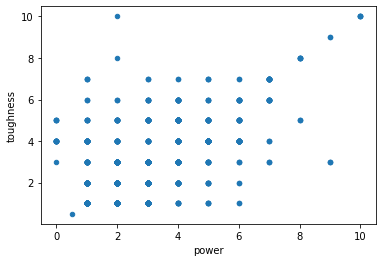

In [29]:
power_v_toughness = new_df.plot.scatter(x='power', y='toughness')

In [30]:
new_df['just_date'] = new_df['released_at'].dt.date

In [31]:
new_df['just_date']

41       2005-07-29
79       2006-10-06
82       1995-04-01
90       1997-05-01
197      2011-05-13
            ...    
61370    2011-01-10
61427    1999-07-01
61476    1999-07-06
61502    2019-10-04
61510    2015-07-17
Name: just_date, Length: 1069, dtype: object

In [32]:
new_df.dtypes

type_line                object
power                   float64
toughness               float64
released_at      datetime64[ns]
cmc                     float64
power_adj               float64
toughness_adj           float64
just_date                object
dtype: object

In [33]:
#plt.scatter(new_df['just_date'], new_df['toughness'])
#plt.scatter(new_df['just_date'], new_df['power'])
new_df['date_numeric'] = new_df['just_date'].apply(date2num)

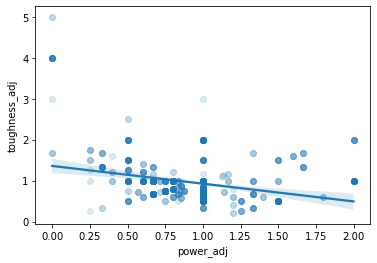

In [34]:
sns.regplot(data=new_df, x="power_adj", y="toughness_adj", scatter_kws={'alpha':0.15})

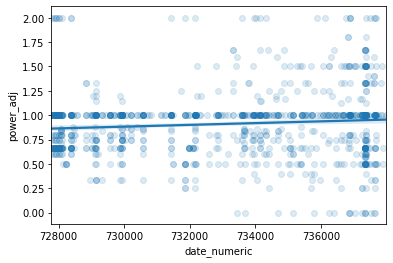

In [35]:
sns.regplot(data=new_df, x="date_numeric", y="power_adj", scatter_kws={'alpha':0.15})

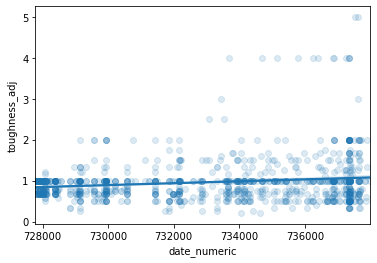

In [36]:
#plt.scatter(new_df['date_numeric'], new_df['toughness_adj'])
sns.regplot(data=new_df, x="date_numeric", y="toughness_adj", scatter_kws={'alpha':0.15})

I used code from https://stackoverflow.com/questions/54043768/add-regression-line-and-ellipse-to-a-3d-scatter-plot-in-python to do line fitting. 

<IPython.core.display.Javascript object>


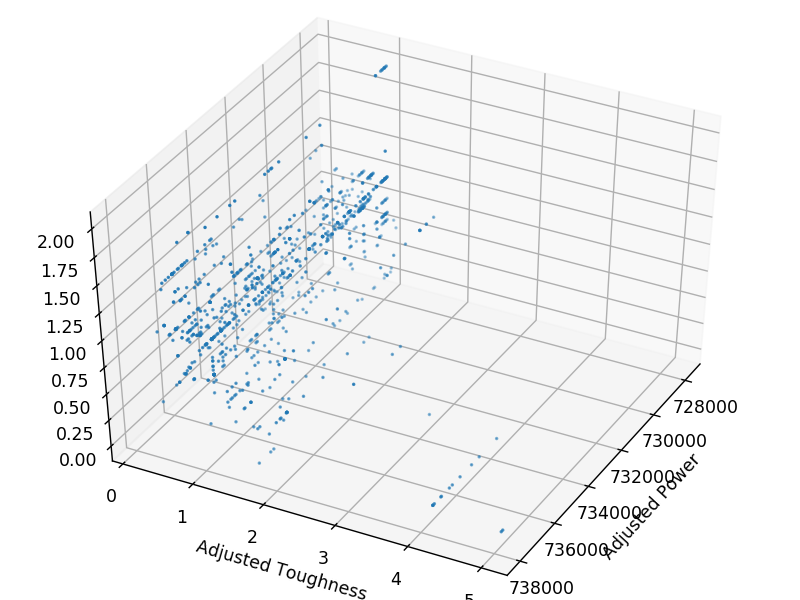

In [38]:
%matplotlib notebook
fig = plt.figure()
ax = Axes3D(fig)
#ax.scatter(new_df['power_adj'], new_df['toughness_adj'], new_df['date_numeric'], s = 1)
ax.scatter(new_df['date_numeric'], new_df['toughness_adj'], new_df['power_adj'], s = 1)
plt.xlabel("Adjusted Power")
plt.ylabel("Adjusted Toughness")

#X = new_df[['power_adj', 'toughness_adj', 'date_numeric']].values
#Xlen = X.shape[0]
#avgPointCloud = 1 / Xlen * np.array([np.sum(X[:, 0]), np.sum(X[:, 1]), np.sum(X[:, 2])])
#Xmean = X - avgPointCloud

#cov = 1 / Xlen * X.T.dot(Xmean)

#t = np.arange(-10, 30, 1)
#linearReg = avgPointCloud + cov[:, 0] * np.vstack(t)

#ax.plot(linearReg[:, 0], linearReg[:, 1], linearReg[:, 2], 'r')
plt.show()
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
    plt.show()

Some observations:

It's less expensive to pay for better value in toughness than in power. On the extreme end for toughness, we have 5 toughness for 1 mana. The best power efficiency is 2 power for 1 mana. 

One idea: examine list of banned cards in Standard/Historic and look at 